In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai import *          # Quick access to most common functionality
from fastai.tabular import *  # Quick access to tabular functionality
from fastai.gen_doc.nbdoc import *
from fastai.tabular import *
from fastai import *
from fastai.tabular.models import *

In [4]:
import pandas as pd
import numpy as np
from random import sample, randint
import os, datetime
from pathlib import Path
import itertools
import pickle
# Import the email modules we'll need
from pandas_ml import ConfusionMatrix
from tpot.builtins import StackingEstimator
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from pandas.api.types import is_string_dtype, is_numeric_dtype


AttributeError: module 'pandas.compat' has no attribute 'iteritems'

In [4]:
feather_file = os.path.join('.', 'data/total_data_filled.feather')
VALID_DAYS = 20

In [5]:
df = pd.read_feather(feather_file)
df = df.set_index([ 'index', 'day'])

/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [6]:
print(df.head())

                          LCLid  energy_median  energy_mean  energy_max  \
index     day                                                             
MAC000002 2012-10-12  MAC000002         0.1385     0.154304       0.886   
          2012-10-13  MAC000002         0.1800     0.230979       0.933   
          2012-10-14  MAC000002         0.1580     0.275479       1.085   
          2012-10-15  MAC000002         0.1310     0.213688       1.164   
          2012-10-16  MAC000002         0.1450     0.203521       0.991   

                      energy_count  energy_std  energy_sum  energy_min  \
index     day                                                            
MAC000002 2012-10-12            46    0.196034       7.098       0.000   
          2012-10-13            48    0.192329      11.087       0.076   
          2012-10-14            48    0.274647      13.223       0.070   
          2012-10-15            48    0.224483      10.257       0.070   
          2012-10-16          

In [7]:
df = df.drop(['energy_median','energy_mean','energy_max','energy_count',
                  'energy_std','energy_min','energy_skewness','energy_kurtosis', "temperatureMaxTime", "temperatureMinTime", "apparentTemperatureMinTime",
                    "apparentTemperatureHighTime","sunsetTime", "uvIndexTime"  ,"sunriseTime","temperatureHighTime", "temperatureLowTime", 
                     "apparentTemperatureMaxTime",
                     "apparentTemperatureLowTime"], axis = 1)

In [8]:
print(df.head())

                          LCLid  energy_sum energey_max_usage_hour stdorToU  \
index     day                                                                 
MAC000002 2012-10-12  MAC000002       7.098                     19      Std   
          2012-10-13  MAC000002      11.087                     10      Std   
          2012-10-14  MAC000002      13.223                     18      Std   
          2012-10-15  MAC000002      10.257                     19      Std   
          2012-10-16  MAC000002       9.769                     12      Std   

                        Acorn Acorn_grouped  temperatureMax  windBearing  \
index     day                                                              
MAC000002 2012-10-12  ACORN-A      Affluent           11.53        252.0   
          2012-10-13  ACORN-A      Affluent           12.32        300.0   
          2012-10-14  ACORN-A      Affluent           13.03        220.0   
          2012-10-15  ACORN-A      Affluent           14.74       

In [9]:
max_date = max(df.index)[1]
valid_start_day = max_date - datetime.timedelta(days = VALID_DAYS)       
train_idx = list(filter(lambda t: t[1] <= valid_start_day, df.index))
valid_idx = list(filter(lambda t: t[1] > valid_start_day, df.index))
print(df.columns)

Index(['LCLid', 'energy_sum', 'energey_max_usage_hour', 'stdorToU', 'Acorn',
       'Acorn_grouped', 'temperatureMax', 'windBearing', 'icon', 'dewPoint',
       'cloudCover', 'windSpeed', 'pressure', 'apparentTemperatureHigh',
       'precipType', 'visibility', 'humidity', 'apparentTemperatureLow',
       'apparentTemperatureMax', 'uvIndex', 'temperatureLow', 'temperatureMin',
       'temperatureHigh', 'summary', 'apparentTemperatureMin', 'moonPhase',
       'temperature_skewness', 'temperature_kurtosis', 'day_length',
       'day.of.week', 'Type', 'before_holiday', 'after_holiday', 'month',
       'year', 'temperatureMaxHour', 'temperatureMinHour',
       'apparentTemperatureMinHour', 'apparentTemperatureHighHour',
       'sunsetHour', 'uvIndexHour', 'sunriseHour', 'temperatureHighHour',
       'temperatureLowHour', 'apparentTemperatureMaxHour',
       'apparentTemperatureLowHour'],
      dtype='object')


In [10]:
cat_names = ['LCLid','Acorn', 'Acorn_grouped', "icon", "stdorToU", "Type", "day.of.week", 'precipType',  'summary', 
                   'before_holiday', 'after_holiday', 'month', 'year']
df = df.drop(['energey_max_usage_hour'], axis = 1)

In [11]:
dep_var = 'energy_sum'
cont_names = list(filter(lambda x: x not in cat_names, df.columns))

In [12]:
train_df = df.loc[train_idx]
valid_df = df.loc[valid_idx]

In [13]:
path = Path('./data')
for v in cat_names:
            df[v] = df[v].astype('category').cat.as_ordered()

In [18]:
#df = df.reset_index()
#df = df.drop(['day', 'index'] , axis = 1)
print(df.head().T)


index                                           MAC000002  \
day                                            2012-10-12   
LCLid                                           MAC000002   
energy_sum                                          7.098   
stdorToU                                              Std   
Acorn                                             ACORN-A   
Acorn_grouped                                    Affluent   
temperatureMax                                      11.53   
windBearing                                           252   
icon                                    partly-cloudy-day   
dewPoint                                             6.15   
cloudCover                                           0.29   
windSpeed                                            2.18   
pressure                                          1004.92   
apparentTemperatureHigh                             11.53   
precipType                                           rain   
visibility              

In [19]:
data = TabularDataBunch.from_df(path, train_df, valid_df, dep_var, 
                                tfms=[FillMissing, Categorify], cat_names=cat_names)

/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/fastai/tabular/transform.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[n] = df[n].astype('category').cat.as_ordered()
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/fastai/tabular/transform.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[n] = pd.Categorical(df[n], categories=self.categories[n], ordered=True)


In [20]:
def rmspe(y_pred, targ):
    y_mean = y_pred.mean()
    pct_var = (targ - y_pred)/y_mean
    return math.sqrt((pct_var**2).mean())

y_min, y_max = df[dep_var].min(), df[dep_var].max()*1.1

print(y_min, y_max)

0.0 365.81160109999985


In [23]:
learn = get_tabular_learner(data, layers=[256,128], metrics=[rmspe], y_range=[y_min, y_max])
lr = 1e-3

epoch  train loss  valid loss  rmspe


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


1      12960.021484


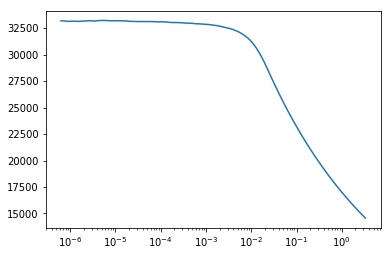

In [24]:
learn.lr_find()
learn.recorder.plot()


In [ ]:
lr = 1e-3
learn.fit(3,lr)

epoch  train loss  valid loss  rmspe


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
